# Assignment

We build on the feature engineering we did in the last assignment and run k-means on the data with RFM features in order to do **customer segmentation**. Since k-means is unsupervised, we will also encounter challenges around interpreting results at the end. 

In [67]:
import pandas as pd
col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("../data/retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


Run the feature engineering steps on the data to extract RFM features.  

In [68]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


The RFM features are:  'dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays'

1. Train a k-means algorithm on the 3 normalized RFM features using $k = 10$. What are the cluster centroids? The cluster centroids should be reported in the **original scale**, not the normalized scale. <span style="color:red" float:right>[2 point]</span> 

In [69]:
# Add code here

# Normalize data 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(
    churn_roll[["dollar_roll_sum_7D", "quantity_roll_sum_7D", "last_visit_ndays"]]
)
normalized_df = pd.DataFrame(normalized_data, columns=["dollar_roll_sum_7D", "quantity_roll_sum_7D", "last_visit_ndays"])
normalized_df[:10]

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,-0.391987,-0.369911,1.555365
1,-0.325518,-0.461491,-0.614759
2,-0.024965,-0.186752,-0.886024
3,-0.291802,-0.186752,-0.072228
4,-0.240747,-0.369911,1.555365
5,0.168179,0.225358,-0.781691
6,0.010678,0.133778,1.555365
7,0.452838,0.408517,-0.823424
8,-0.385725,-0.461491,0.741569
9,0.308823,0.500097,1.555365


In [70]:
from sklearn.cluster import KMeans

number_of_clusters = 10
# Instantiate a KMeans object with 10 clusters
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0, n_init=10)

# Fit the model to your data
kmeans.fit(normalized_df)

# Get the cluster centers
cluster_assignments = kmeans.predict(normalized_df)

# Reverse the normalization
centroids = scaler.inverse_transform(kmeans.cluster_centers_)

# Print the centroids
print(centroids)

[[6.89586750e+02 7.56060606e+00 4.87014260e+01]
 [9.42505903e+02 1.02865364e+01 1.17321659e+02]
 [2.10940704e+04 9.10000000e+01 1.17887324e+01]
 [3.18266628e+03 3.36535948e+01 1.19073433e+01]
 [1.98044000e+04 9.72800000e+02 3.60000000e+00]
 [4.51157778e+04 2.31296296e+02 6.18518519e+00]
 [6.31378226e+03 6.88568548e+01 4.20342742e+01]
 [4.57154360e+02 6.13279091e+00 1.09207860e+01]
 [7.62720213e+03 2.79335106e+01 2.40797872e+01]
 [1.53561022e+03 1.72776985e+01 8.56496288e+00]]


2. Our earlier choice of $k=10$ was arbitrary. To find a better number of $k$ create a **scree plot**, which plots the number of clusters $k$ on the x-axis and the sum of squared distances from each point to its cluster centroid on the y-axis. We can get the latter by calling the `inertia_` attribute as shown in the lab. Plot the scree plot for $k$ values from 1 to 15. <span style="color:red" float:right>[4 point]</span>

In [71]:
# Add code here
inertia_values = []

for i in range(1, 16):
  kmeans = KMeans(n_clusters=i, n_init=5).fit(normalized_df)
  inertia_values.append(kmeans.inertia_)

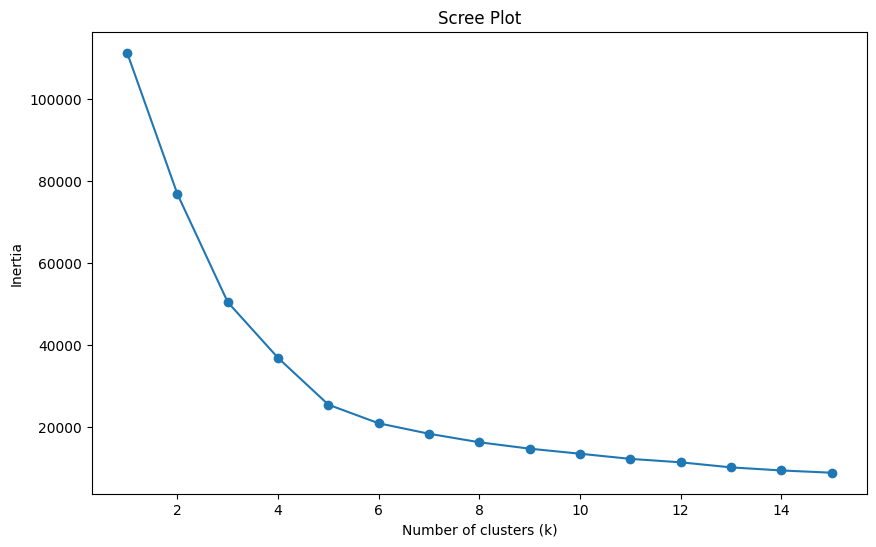

In [72]:
import matplotlib.pyplot as plt

# plot a graph
plt.figure(figsize=(10, 6))
plt.title('Scree Plot')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.plot(range(1, 16), inertia_values, marker='o')
plt.show()

3. Based on the scree plot, what is a good value to pick for $k$? Provide a brief justification for your choice. <span style="color:red" float:right>[2 point]</span>

In [73]:
# Let's calculate the decrease in inertia when moving from one cluster to another
inertia_decrease_3_to_4 = inertia_values[2] - inertia_values[3]
inertia_decrease_4_to_5 = inertia_values[3] - inertia_values[4]
inertia_decrease_5_to_6 = inertia_values[4] - inertia_values[5]
inertia_decrease_6_to_7 = inertia_values[5] - inertia_values[6]

# Print out the rate of inertia decrease for each consecutive pair of clusters
# This quantitatively represents how much the inertia decreases when adding one more cluster
print(f"Rate of inertia decrease when going from 3 to 4 clusters: {inertia_decrease_3_to_4/inertia_decrease_4_to_5}")
print(f"Rate of inertia decrease when going from 4 to 5 clusters: {inertia_decrease_4_to_5/inertia_decrease_5_to_6}")
print(f"Rate of inertia decrease when going from 5 to 6 clusters: {inertia_decrease_5_to_6/inertia_decrease_6_to_7}")

Rate of inertia decrease when going from 3 to 4 clusters: 1.1924292289115381
Rate of inertia decrease when going from 4 to 5 clusters: 2.510481821179431
Rate of inertia decrease when going from 5 to 6 clusters: 1.7812153463607814


**Add Comment here**   
Based on the scree plot, I would choose 5 as the optimal number of clusters. The reason for this choice is that after 5 clusters, the rate at which the inertia decreases becomes notably slower. This means that adding more clusters after 5 doesn't give us as much improvement in defining distinct groups within the data. Thus, it seems reasonable to pick 5 as the ideal balance between having a manageable number of clusters and minimizing within-cluster variance.

4. Train a k-means algorithm on the RFM features using your new value of $k$. Report:
- the size (number of items) of each cluster
- the mean of each cluster in the original scale
- the standard deviation of each cluster in the Z-normalized scale
<span style="color:red" float:right>[2 point]</span>

In [74]:
# Add code here

number_of_clusters = 5
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0, n_init=10)
kmeans.fit(normalized_df)

# Getting the cluster assignments for each data point
labels = kmeans.labels_

# Append the labels to the original and normalized dataframe
churn_roll['cluster'] = labels
normalized_df['cluster'] = labels

# Reporting the size of each cluster
print("Cluster Sizes:")
print(churn_roll['cluster'].value_counts())

# Calculating and reporting the mean of each cluster in the original scale
print("\nCluster Means (Original Scale):")
print(churn_roll.groupby('cluster').mean(numeric_only=True))

# Calculating and reporting the standard deviation of each cluster in the Z-normalized scale
print("\nCluster Standard Deviations (Z-normalized Scale):")
print(normalized_df.groupby('cluster').std())


Cluster Sizes:
0    23142
2    10636
4     3213
1       57
3       10
Name: cluster, dtype: int64

Cluster Means (Original Scale):
              user_id  dollar_roll_sum_7D  quantity_roll_sum_7D  \
cluster                                                           
0        1.371139e+06          833.555484              9.972993   
1        1.568358e+06        35457.385965            165.982456   
2        1.480733e+06          927.462768             10.117243   
3        2.002109e+06        19804.400000            972.800000   
4        1.327687e+06         4466.095549             39.548708   

         last_visit_ndays  
cluster                    
0               14.182741  
1               10.543860  
2              114.889902  
3                3.600000  
4               18.602552  

Cluster Standard Deviations (Z-normalized Scale):
         dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
cluster                                                            
0               

5. Pick 3 clusters at random and describe what makes them different from one another (in terms of their RFM features). <span style="color:red" float:right>[3 point]</span>

**Add Comment here**  


Cluster 0: This is the biggest cluster, hosting 23142 customers. On average, each customer spends around $800 and purchases roughly 10 items. This indicates these customers are regular shoppers.

Cluster 2: This cluster is approximately 7 times smaller than Cluster 0. However, customers here spend about 5 times more and buy 4 times more items than those in Cluster 0. Their last visit isn't too different from regular customers. This group can be labeled as high-spending customers.

Cluster 4: This cluster includes a tiny fraction of customers (only 10), but they demonstrate high spending and a large quantity of items bought. Their last visit record is incredibly low, implying very recent visits. Given these extraordinary traits, we can classify this group as outliers.

# End of assignment